In [41]:
import tensorflow
import os

In [66]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
import gzip
import numpy
import json

import tensorflow as tf
import pickle
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

In [3]:
class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
    
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
#       if reshape:
# #         assert images.shape[3] == 1

      images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])
#       images = images.reshape(1, images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)
      ]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]

In [4]:
def read_data_sets(data_dict, fake_data=False, one_hot=False, dtype=dtypes.float32, reshape=True, validation_size=5000):
    train_images = np.array(data_dict['X_train'])
    train_labels = np.array(data_dict['y_train'])
    test_images = np.array(data_dict['X_test'])
    test_labels = np.array(data_dict['y_test'])
    if not 0 <= validation_size <= len(train_images):
        raise ValueError('Validation size should be between 0 and {}. Received: {}.'.format(len(train_images), validation_size))

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    train = DataSet(train_images, train_labels, dtype=dtype, reshape=reshape)
#     validation = DataSet(validation_images, validation_labels, dtype=dtype, reshape=reshape)
#     test = DataSet(test_images, test_labels, dtype=dtype, reshape=reshape)
    validation = DataSet(validation_images, validation_labels, dtype=dtype, reshape=reshape)
    test = DataSet(test_images, test_labels, dtype=dtype, reshape=reshape)
    return base.Datasets(train=train, validation=validation, test=test)

In [5]:
def flatten_matrix(matrix):
    vector = matrix.flatten(1)
    vector = vector.reshape(1, len(vector))
    return vector

In [6]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return {"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

In [7]:
def normalizer(label):
    return ((label - np.min(label)) / (np.max(label) - np.min(label))) * 0.8 + 0.1

In [68]:
def read_data_from_processed_pickle(pickle_data):
    print("read processed pickle...")
    with open("processed_pickle/%s"%pickle_data, 'rb') as handle:
        data = pickle.load(handle)
        return data

In [92]:
path = os.getcwd() + "/processed_pickle"
processed_pickles = [item for item in os.listdir(path) if item.endswith(".pickle")]
processed_pickles = processed_pickles[:5]

In [93]:
processed_data2 = [[], []]
for item in processed_pickles:
    print("getting %s" % item)
    tmp_data = read_data_from_processed_pickle(item)
    processed_data2[0].extend(tmp_data[0])
    processed_data2[1].extend(tmp_data[1])

getting torcs_data_10000.pickle
read processed pickle...
getting torcs_data_100000.pickle
read processed pickle...
getting torcs_data_110000.pickle
read processed pickle...
getting torcs_data_120000.pickle
read processed pickle...
getting torcs_data_130000.pickle
read processed pickle...


In [91]:
len(processed_data2[1])

20000

In [71]:
with open('processed_pickle/torcs_data_10000.pickle', 'rb') as handle:
    processed_data = pickle.load(handle)


In [88]:
processed_data[1][:2]

[{'key': '00000001',
  'label': [0.2483597993850708,
   -7.0,
   3.5,
   7.0,
   75.0,
   75.0,
   -6.2476959228515625,
   -2.2476959228515625,
   1.7523040771484375,
   5.7523040771484375,
   60.0,
   50.1171875,
   41.09765625,
   1.0]},
 {'key': '00000002',
  'label': [0.24839413166046143,
   -7.0,
   3.5,
   7.0,
   75.0,
   75.0,
   -6.333146095275879,
   -2.333146095275879,
   1.666853904724121,
   5.666853904724121,
   60.0,
   50.94677734375,
   41.8720703125,
   1.0]}]

In [121]:
# WIDTH = 280
# HEIGHT = 212
WIDTH = 52
HEIGHT = 72
channel = 1
n_class = 14

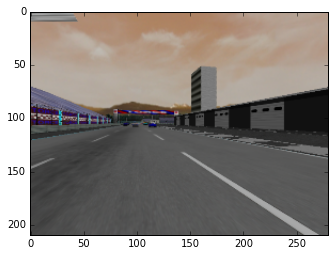

In [119]:
plt.imshow(processed_data[0][:1][0]['image'])

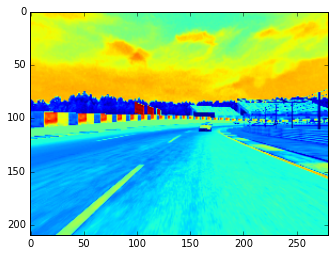

In [120]:
plt.imshow(processed_data[0][380]['image'][:,:,2])

In [117]:
images_data = []
labels_data = []
for idx in range(10):
    image = processed_data[0][idx]['image']
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    img_gray = cv2.resize(img_gray, (HEIGHT, WIDTH))
    
#     img_gray = np.vstack((img_gray, np.zeros((2, 52))))
    images_data.append(img_gray)
    labels_data.append(processed_data[1][idx]['label'])

In [118]:
images_data[0].shape

(52, 72)

In [107]:
labels_data_norm = pd.DataFrame(labels_data).apply(normalizer, 0).as_matrix()

In [108]:
data_dict = split_data(images_data, labels_data_norm)

In [109]:
sample_size = len(data_dict['y_train'])

In [110]:
images_data[0].shape

(52, 72)

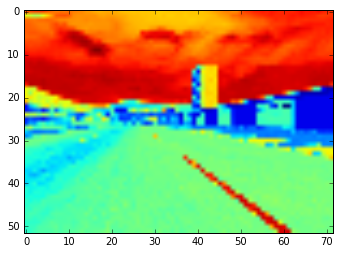

In [113]:
plt.imshow(images_data[3])

In [22]:
validation_size= 2000
torcs_data = read_data_sets(data_dict, one_hot=False, validation_size= validation_size)

In [89]:
########################### Architecture #######################

In [23]:
# Weight Initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolution and Pooling
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [24]:
x = tf.placeholder(tf.float32, [None, WIDTH * HEIGHT * channel])
W = tf.Variable(tf.zeros([WIDTH * HEIGHT * channel, n_class]))
b = tf.Variable(tf.zeros([n_class]))
y_ = tf.placeholder(tf.float32, [None, n_class])

In [25]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [26]:
x_image = tf.reshape(x, [-1, WIDTH, HEIGHT, channel])

In [27]:
W_conv1 = weight_variable([5, 5, channel, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [28]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3) + b_conv3)

h_pool2 = max_pool_2x2(h_conv3)

In [29]:
W_fc1 = weight_variable([(HEIGHT // 4) * (WIDTH // 4) * 128, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, (HEIGHT // 4) * (WIDTH // 4) * 128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [30]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [31]:
W_fc2 = weight_variable([1024, n_class])
b_fc2 = bias_variable([n_class])
y_conv= tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [32]:
sample_size = sample_size - validation_size
cost_function = tf.reduce_sum(tf.pow(y_ - y_conv, 2))/(2 * sample_size ) #L2 loss

In [33]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost_function)
mse = tf.reduce_sum(tf.pow(y_ - y_conv, 2))/(2 * sample_size )
sess.run(tf.initialize_all_variables())

In [39]:
accuracy_lst = []
for i in range(2):
    batch = torcs_data.train.next_batch(10)
    if i % 100 == 0:
        train_accuracy = mse.eval(session=sess, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        with open('data.txt', 'w') as outfile:
            json.dump(str(accuracy_lst), outfile)
    accuracy_lst.append(train_accuracy)
    print("step %d, training mse %g"%(i, train_accuracy))
    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
with open('data.txt', 'w') as outfile:
    json.dump(str(accuracy_lst), outfile)


step 0, training mse 266.701
step 1, training mse 100.992
[266.70132, 100.99173]


In [38]:
with open('data.txt', 'w') as outfile:
    json.dump(str(accuracy_lst), outfile)

In [ ]:
tuning_cost = sess.run(cost_function, feed_dict={x:batch[0], y_: batch[1]})
print "Tuning completed:", "cost=", "{:.9f}".format(tuning_cost), "W=", sess.run(W), "b=", sess.run(b)

In [ ]:
testing_cost = sess.run(cost_function, feed_dict={X: size_data_test_n, Y: price_data_test_n})
